# Testing the BoARIO


## Following the quickstart example
This script runs the example used on the BoARIO documentation.

In [19]:
# import pymrio for the test MRIOT
import pymrio

# import the different classes
from boario.extended_models import ARIOPsiModel  # The core of the model

In [20]:
mriot = pymrio.load_test().calc_all()

In [21]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [22]:
model = ARIOPsiModel(mriot)

/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/boario/model_base.py:277: UserWarning: No capital to VA dictionary given, considering 4/1 ratio
  warnings.warn("No capital to VA dictionary given, considering 4/1 ratio")


In [23]:
from boario.simulation import Simulation  # Simulation wraps the model

sim = Simulation(model, n_temporal_units_to_sim=40)

In [24]:
from boario import event

# Instantiate an event.
ev = event.from_scalar_regions_sectors(
    impact=10000,
    event_monetary_factor=10**6,
    duration=15,
    event_type="rebuild",
    affected_regions=["reg3"],
    affected_sectors=["manufactoring", "mining"],
    impact_sectoral_distrib=model.mriot.x.loc["reg3", "indout"],
    impact_regional_distrib="equal",
    rebuilding_sectors={"construction": 1},
    rebuild_tau=180,
)

In [25]:
# Add the event to the simulation
sim.add_event(ev)

In [26]:
# Launch the simulation
sim.loop()

<Axes: xlabel='step'>

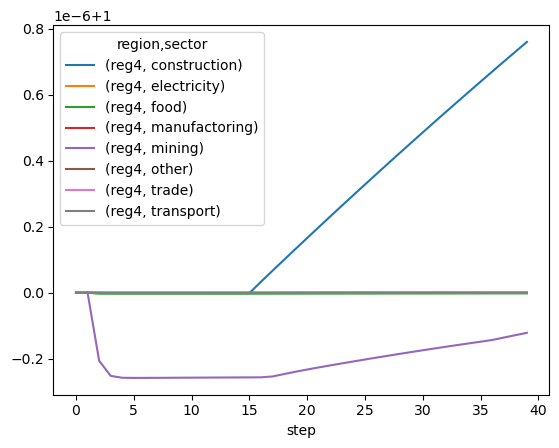

In [27]:
# You can generate a dataframe of
# the production with the following line
df = sim.production_realised
# This allows to normalize production at its initial level
df = df / df.loc[0]

df.loc[:, ("reg4", slice(None))].plot()

## Customising the model
These scripts define the parameters of the model - first by inspecting them. It then downloads data from eora (manual only - pyrmio did not work), before testing the simulation. 

Note - The IOSystem given to instantiate a model requires to contain intermediate demand matrix Z, final demand matrix Y and gross production vector x as attributes, and to be balanced.

In [28]:
import pymrio

model = ARIOPsiModel(
    pym_mrio=mriot,
    order_type="alt",
    alpha_base=1.0,
    alpha_max=1.25,
    alpha_tau=365,
    rebuild_tau=60,
    main_inv_dur=90,
    monetary_factor=10**6,
    temporal_units_by_step=1,
    iotable_year_to_temporal_unit_factor=365,
    infinite_inventories_sect=None,
    inventory_dict=None,
    productive_capital_vector=None,
    productive_capital_to_VA_dict=None,
    psi_param = 0.80,
    inventory_restoration_tau = 60,
)

/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/boario/model_base.py:277: UserWarning: No capital to VA dictionary given, considering 4/1 ratio
  warnings.warn("No capital to VA dictionary given, considering 4/1 ratio")


Loading in data from pymrio to initiate model

In [29]:
import pymrio
eora_storage = "data/tmp/eora26"

# eora26 must be manually downloaded from https://www.eora.info/

# eora_log = pymrio.download_eora26(
#     storage_folder=eora_storage,
#     email="",
#     password="",
#     years=[2009],
#     ) # downloads all
# print(eora_log)

In [30]:
import pymrio
print(pymrio.__version__)

eora = pymrio.parse_eora26(year=2009, path=eora_storage)
print(type(eora))  # Should be <class 'pymrio.core.mriosystem.IOSystem'>

0.5.4


/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1962: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=0, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=Tr

<class 'pymrio.core.mriosystem.IOSystem'>


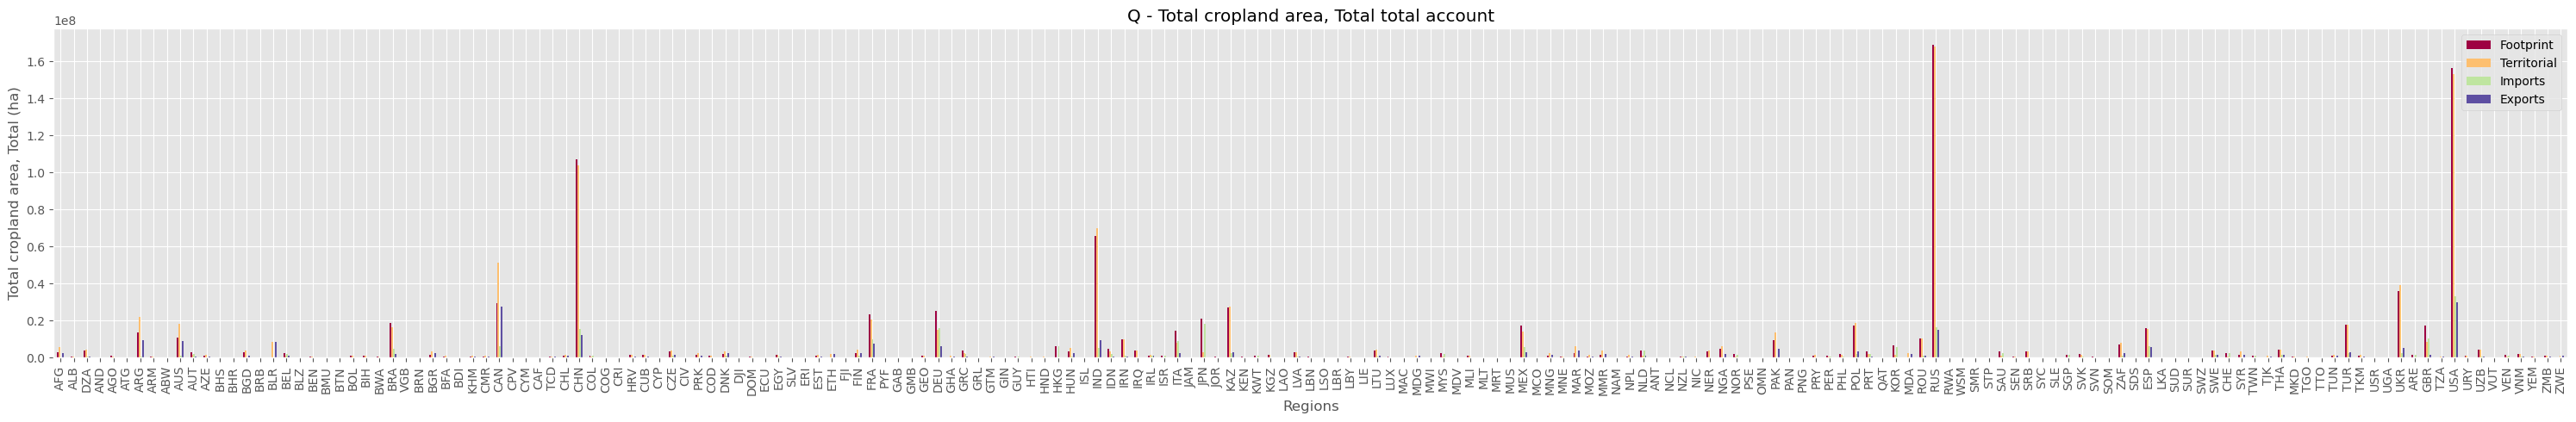

In [31]:
eora.calc_all()

import matplotlib.pyplot as plt

with plt.style.context("ggplot"):
    eora.Q.plot_account(("Total cropland area", "Total"), figsize=(30, 5))
    plt.show()

## Testing with EORA data and example event/impact
These cells parse the eora dataset using pymrio, and set up the ARIOsiModel with test parameters, simulating a shock to Russian Agriculture (because eora does not disaggregate more). 

First, we can inspect the eora. class which contains the basic information in the eora set up. 

In [32]:
import pandas as pd

eora.get_extensions()
list(eora.get_extensions())

sectors = eora.get_sectors()
final_demand = eora.get_Y_categories()

# Get sectors and create a DataFrame
sectors = eora.get_sectors()
sectors_df = pd.DataFrame(sectors)

# Get regions and create a DataFrame
regions = eora.get_regions()
regions_df = pd.DataFrame(regions)

# Get final demand categories and create a DataFrame
final_demand = eora.get_Y_categories()
final_demand_df = pd.DataFrame(final_demand)

# If you want to see the extensions (environmental/social indicators)
extensions = eora.get_extensions()
extensions_df = pd.DataFrame(list(extensions))

# View the first few rows of each DataFrame
print("Sectors:")
print(sectors_df.head())
print("\nRegions:")
print(regions_df.head())
print("\nFinal Demand Categories:")
print(final_demand_df.head())
print("\nSatellites:")
print(extensions_df.head())

Sectors:
                         sector
0                   Agriculture
1                       Fishing
2          Mining and Quarrying
3              Food & Beverages
4  Textiles and Wearing Apparel

Regions:
  region
0    AFG
1    ALB
2    DZA
3    AND
4    AGO

Final Demand Categories:
                                          category
0                 Household final consumption P.3h
1  Non-profit institutions serving households P.3n
2                Government final consumption P.3g
3               Gross fixed capital formation P.51
4                      Changes in inventories P.52

Satellites:
    0
0   Q
1  VA


Saving txt files as pkl for calculations. The pickled files should be in the format required via parsing from pymrio. TBD on this. 

In [33]:
import pymrio
import os

# First check valid eora object
eora = pymrio.parse_eora26(year=2009, path=eora_storage)

# Create the directory
eora_pkl = "data/tmp/eora/Eora26_2009_pkl/"
os.makedirs(eora_pkl, exist_ok=True)

## Pickle
# Save to pickle format
eora.save_all(path=eora_pkl, table_format="pkl")

# Load the pickled data
eora = pymrio.load_all(path=eora_pkl)


/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1962: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=0, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=True)
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/tools/ioparser.py:1949: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  eora_data[key].drop(row_name, axis=1, inplace=Tr

Trying to calibrate the io model to take custom information, like the eora mriot and a new damage sector etc. Here we consider a 500,000 impact to Russian Agriculture, assuming that the rebuilding sectors are major inputs to agriculture including fertilisers, which are part of an aggregated category. 

Some still to answer considerations of an agricultural shock: 
- what are the rebuilding sectors? 
    - fires: machinery
    - heat: labour
- what is the rebuilding time (given that ag is on certain harvest seasons and likely little happens in mid season)
- what is the recovery period? 
- what is the value added to capital ratio? (4:1 is what is default and used in existing studies on hazards affecting infrastructure)
- how can we accommodate unique storage constraints for agriculture?

In [42]:
import pymrio
import warnings

# Suppress the FutureWarning if you want
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Load the Eora data
eora = pymrio.load_all(path=eora_pkl)

# 2. Calculate all required tables
eora = eora.calc_all()

# 3. Now create the model
from boario.extended_models import ARIOPsiModel  # The core of the model

model = ARIOPsiModel(
    pym_mrio=eora,
    order_type="alt",
    alpha_base=1.0,
    alpha_max=1.25,
    alpha_tau=365,
    rebuild_tau=60,
    main_inv_dur=90,
    monetary_factor=10**6,
    temporal_units_by_step=1,
    iotable_year_to_temporal_unit_factor=365
)

import pandas as pd
impact = pd.Series(
    data=[500000],
    index=pd.MultiIndex.from_product(
        [["RUS"], ["Agriculture"]], names=["region", "sector"]
    ),
)

from boario import event

ev = event.from_series(
    impact=impact,
    event_type="rebuild",
    rebuild_tau=60,
    rebuilding_sectors={"Agriculture": 0.8, "Petroleum, Chemical and Non-Metallic Mineral Products": 0.2},
    rebuilding_factor=0.9,
    occurrence=1,
    duration=7,
    name="Heatwave",
)

from boario.simulation import Simulation

# Create a new simulation with your Eora model
sim = Simulation(
    model=model,  # This is your ARIOPsiModel with Eora data
    n_temporal_units_to_sim=365,  # simulation length
    register_stocks=True,  # track stocks
    show_progress=True,  # show progress during simulation
    save_events=True, 
    save_params=True, 
    save_index=True, 
    save_records=[], 
    boario_output_dir='/Users/cmor7802/repos/climpyplots/boario/results/boario-eora-09', 
    results_dir_name=None, 
)

# Now try adding the event
sim.add_event(ev)

# Launch the simulation
sim.loop()

/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/boario/model_base.py:252: UserWarning: Found negative values in the value added, will set to 0. Note that industries with null value added will have a null productive capital if it is defined from value added.
                industries with negative VA: MultiIndex([('ABW',              'Agriculture'),
            ('ABW',                  'Fishing'),
            ('ABW',           'Metal Products'),
            ('ABW',                   'Others'),
            ('ABW',      'Transport Equipment'),
            ('ALB',                'Recycling'),
            ('ANT', 'Electrical and Machinery'),
            ('ANT',      'Other Manufacturing'),
            ('ANT',    'Re-export & Re-import'),
            ('ANT',                'Recycling'),
            ...
            ('SWE',             'Retail Trade'),
            ('SWZ',                'Recycling'),
            ('TJK',    'Re-export & Re-import'),
            ('TZA',    'Re-export & 

Now we can plot the normalised production at each time step to recovery. These parameters need to be set based on the question and the requirements for the case study (ag impacts). 

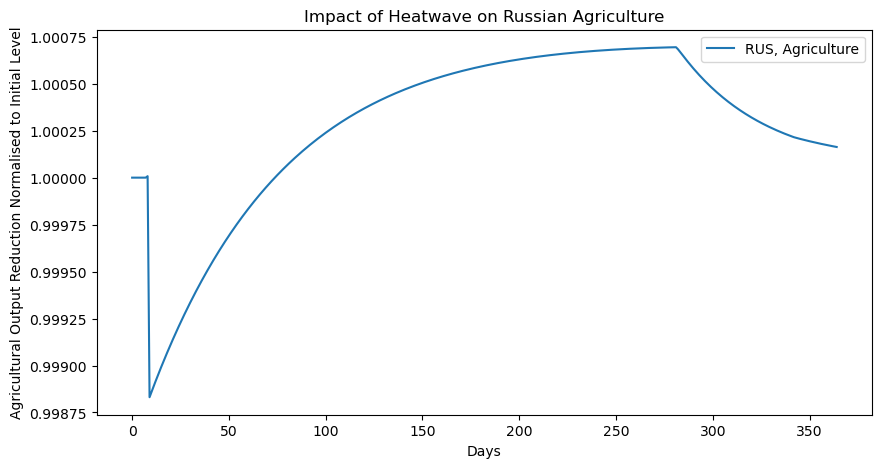

In [43]:
import matplotlib.pyplot as plt

# You can generate a dataframe of
# the production with the following line
df = sim.production_realised
# This allows to normalize production at its initial level
df = df / df.loc[0]

russia = df.loc[:, ("RUS", slice('Agriculture'))]

fig, ax = plt.subplots(figsize=(10, 5))
lines = ax.plot(russia)

ax.set_xlabel("Days")
ax.set_ylabel("Agricultural Output Reduction Normalised to Initial Level")
ax.set_title("Impact of Heatwave on Russian Agriculture")

ax.legend(lines, ['RUS, Agriculture'])

plt.show()

Checking the total output of certain sectors to understand model behaviour and original data. 

First calcluate the total output from the IOT (eora). 

In [45]:
# Calculate the original total output vector from Eora
x_eora = eora.Z.sum(axis=1) + eora.Y.sum(axis=1)

# Extract 'RUS', 'Agriculture'
x_rus_agri = x_eora.loc[('RUS', 'Agriculture')]
print("Original Eora x for Russian Agriculture:", x_rus_agri)

Original Eora x for Russian Agriculture: 124943711.85392609


Next, calculate the production calling calc_production() in the BoARIO set up for the same sector region pair. 

In [46]:
# Calculate production at time 0 (or any time)
model.calc_production(0)

# Get the production vector as a pandas Series
import pandas as pd
prod_series = pd.Series(model.production, index=model.mriot.x.index)

# Extract the value for ('RUS', 'Agriculture')
prod_rus_agri = prod_series.loc[('RUS', 'Agriculture')]
print("Model production for Russian Agriculture at t=0:", prod_rus_agri)

Model production for Russian Agriculture at t=0: 342356.7825826268


Finally, calculate the relative difference to inspect the values. 

In [47]:
print("Difference:", prod_rus_agri - x_rus_agri)
print("Relative difference (%):", 100 * (prod_rus_agri - x_rus_agri) / x_rus_agri)

Difference: -124601355.07134347
Relative difference (%): -99.72599118634886


This is a different way to extract or calculate the production using the BoARIO calc_production(). 

In [49]:
from boario.simulation import Simulation

# Steps to inspect total production (output) of the Russian agricultural sector
# 1. Specify the time step = 0 = before the disaster? 
model.calc_production(0)

# 2. Access the production array (usually model.production or model.production_realised)
# model.production is a numpy array with shape (n_regions * n_sectors,)
# model.mriot provides the MultiIndex for (region, sector)

# 2.1 Get the MultiIndex for (region, sector)
index = model.mriot.x.index  # This is usually a MultiIndex (region, sector)

# 2.2 Convert production to a pandas Series for indexing
import pandas as pd
prod_series = pd.Series(model.production, index=index)

# 3. Extract the value for ('RUS', 'Agriculture')
rus_agri_output = prod_series.loc[('RUS', 'Agriculture')]
print("Total output for Russian Agriculture sector:", rus_agri_output)

# Test other sectors output
rus_fmq_output = prod_series.loc[('RUS', 'Mining and Quarrying')]
print("Total output for Russian Mining and Quarrying sector:", rus_fmq_output)

Total output for Russian Agriculture sector: 342356.7825826268
Total output for Russian Mining and Quarrying sector: 187113.78097329097


Here we can see the evolution of the total output for Russian Agriculture? This needs checking. 

In [ ]:
df = sim.production_realised  # DataFrame of simulation with time as the index
print(df.loc[:, ('RUS', 'Agriculture')])  # Shows the time series for Russian Agriculture

step
0      342311.539326
1      342311.538655
2      342311.538656
3      342311.538656
4      342311.538656
           ...      
360    342370.135032
361    342369.430790
362    342368.738616
363    342368.056701
364    342367.386327
Name: (RUS, Agriculture), Length: 365, dtype: float64


Pre-processing IO data
Requires: 
1) Calculating total output
2) Calculating total input
3) Checking balancing
4) Rebalancing

Then: 
1) Checking final demand for negatives
2) Mirroring to remove negatives
3) Rebalancing
4) Offsetting with very small 0

In [ ]:
# x = Z + Y
# where A = T xhat^-1
import pandas as pd
import numpy as np

# Load the pickled Z and Y matrices
Z = pd.read_pickle('/Users/cmor7802/repos/climpyplots/boario/data/tmp/eora/Eora26_2009_pkl/Z.pkl')
Y = pd.read_pickle('/Users/cmor7802/repos/climpyplots/boario/data/tmp/eora/Eora26_2009_pkl/Y.pkl')
VA = pd.read_pickle('/Users/cmor7802/repos/climpyplots/boario/data/tmp/eora/Eora26_2009_pkl/VA/F.pkl')

# Get the sum of first row for Z
z_row_sum = Z.iloc[0, :].sum()
z_col_sum = Z.iloc[:, 0].sum()

# Get the sum of first row for Y
y_row_sum = Y.iloc[0, :].sum()

# Total output for first row (x = Z + f)
total_output_row1 = z_row_sum + y_row_sum

va_col_sum = VA.iloc[:, 0].sum()

total_input_col1 = va_col_sum + z_col_sum

print(f"Sum of first row in Z: {z_row_sum}")
print(f"Sum of first row in Y: {y_row_sum}")
print(f"Total output (x) for first row: {total_output_row1}")
print(f"Sum of first column in VA: {va_col_sum}")
print(f"Sum of first column in Z: {z_col_sum}")
print(f"Total input (x) for first column: {total_input_col1}")

diff = total_input_col1 - total_output_row1

print(f"Difference between total input and total output: {diff}")

# Find the number of negatives in the Y matrix
negatives_in_Y = (Y < 0).sum().sum()
print(f"Number of negative values in Y: {negatives_in_Y}")

# Find the number of negatives in the Z matrix
negatives_in_Z = (Z < 0).sum().sum()
print(f"Number of negative values in Z: {negatives_in_Z}")


Sum of first row in Z: 399460.126665488
Sum of first row in Y: 205862.86657
Total output (x) for first row: 605322.993235488
Sum of first column in VA: 346257.76999999996
Sum of first column in Z: 248426.25700910893
Total input (x) for first column: 594684.0270091089
Difference between total input and total output: -10638.966226379038
Number of negative values in Y: 673
Number of negative values in Z: 0
